# Visualization of the ${\rm SU}(N)$ Heat Kernel and its Score Function

In this notebook, we will simply plot the heat kernel over the ${\rm SU}(2)$ and ${\rm SU}(3)$ maximal tori in both wrapped-normal and dual-character representations as comparison. We will also look at the score function for the ${\rm SU}(2)$ heat kernel. It is illuminating to examine for what values/thresholds of $\sigma$ each representation gives a stable result, motivating the use of the two formulations.

In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import sun_diffusion

from sun_diffusion.devices import set_device, summary
from sun_diffusion.heat import (
    sun_hk,
    sun_dual_hk,
    sun_score_hk,
    sun_score_dual_hk,
    sun_score_hk_autograd
)

In [3]:
set_device('cpu')
print(summary())

Using device: cpu (CPU) with dtype: torch.float64


## The Heat Kernel

Let us start by looking at the ${\rm SU}(2)$ heat kernel over different levels of the diffusivity (width) $\sigma_t$.

**Note:** Remember to set `eig_meas=True` when plotting the heat kernel! This includes the Haar measure term on the eigenvalues, which ensures that the result is a valid density with respect to the Lebesgue measure.

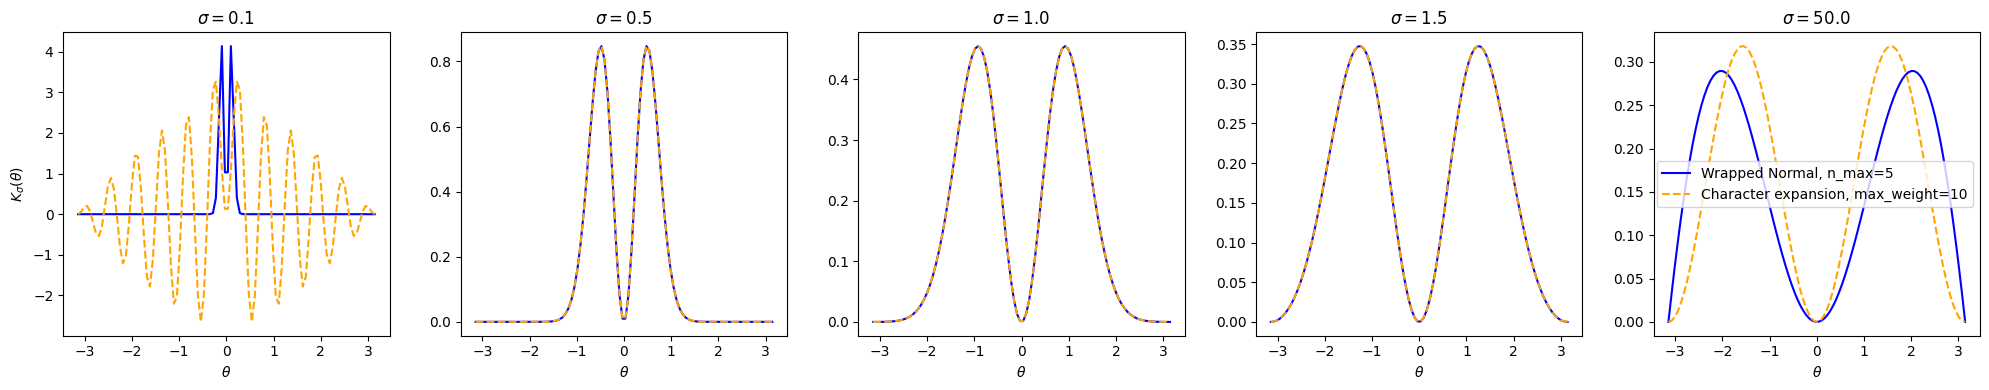

In [4]:
def plot_su2_hk():
    xs = torch.linspace(-np.pi, np.pi, 100)
    dx = xs[1] - xs[0]
    sigmas = [0.1, 0.5, 1.0, 1.5, 50.0]  # can change these to visualize different noise levels
    
    fig, axes = plt.subplots(1, len(sigmas), figsize=(4*len(sigmas), 4))
    axes[0].set_ylabel(r'$K_\sigma(\theta)$')
    for sigma, ax in zip(sigmas, axes):
        ax.set_xlabel(r'$\theta$')
        ax.set_title(rf'$\sigma = {sigma}$')
        width = sigma * torch.ones(xs.shape[0])

        # Wrapped normal (stable for smaller sigma)
        n_max = 5
        K = sun_hk(xs[:, None], width=width, n_max=n_max, eig_meas=True)
        K /= torch.sum(K * dx)
        ax.plot(xs, K, color='blue', ls='-', label=f'Wrapped Normal, n_max={n_max}')
        
        
        # Character expansion (stable for larger sigma)
        max_weight = 10
        K = sun_dual_hk(xs[:, None], width=width, max_weight=max_weight, eig_meas=True)
        K /= torch.sum(K * dx)
        ax.plot(xs, K, color='orange', ls='--', label=f'Character expansion, max_weight={max_weight}')
        
    axes[-1].legend()
    fig.tight_layout()
    fig.show()

plot_su2_hk()

Now, we can also look at and compare the ${\rm SU}(3)$ spectral heat kernel:

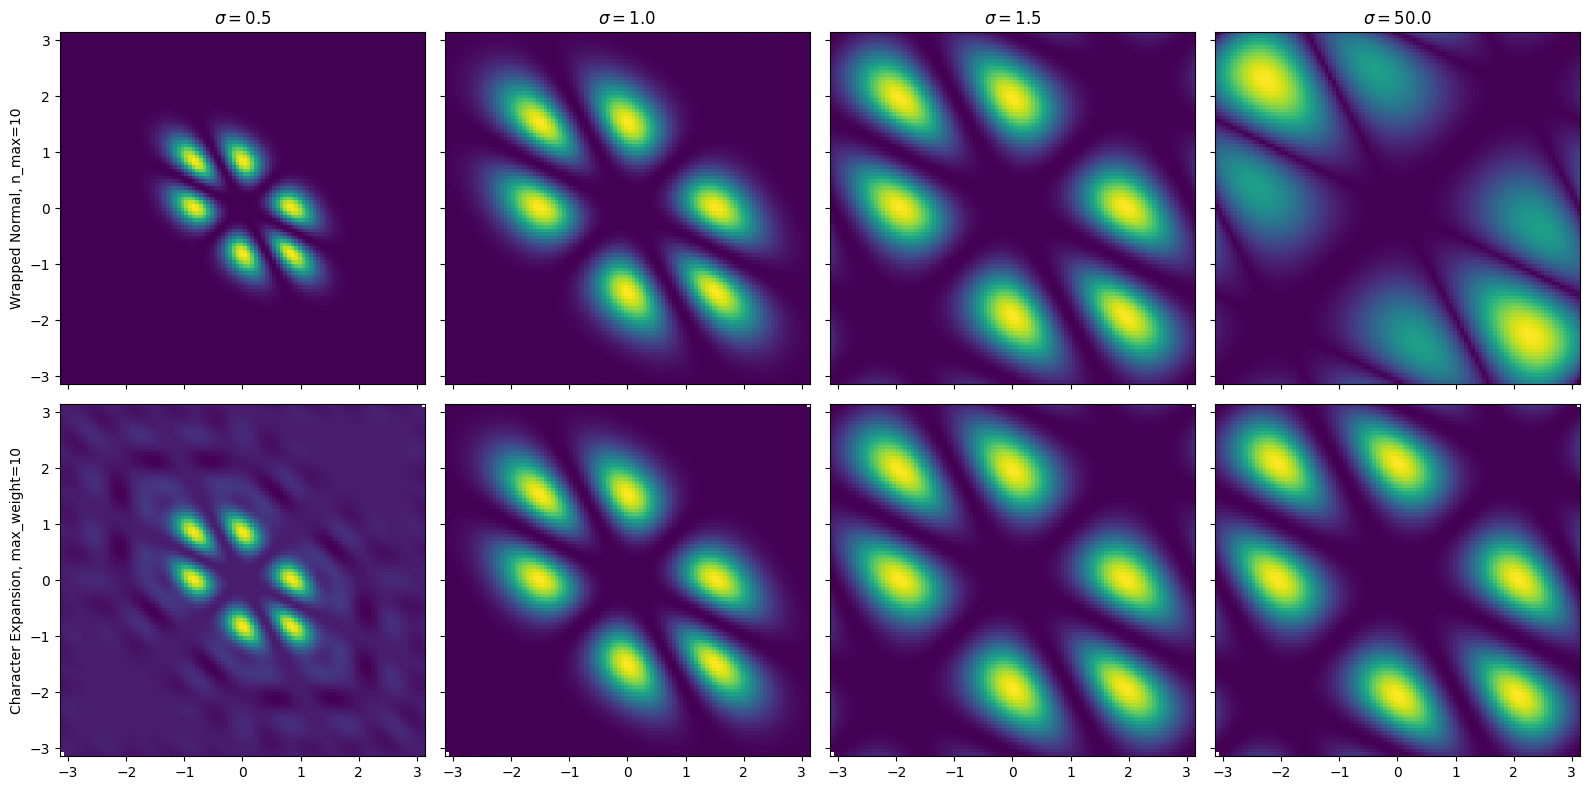

In [5]:
def plot_su3_hk():
    sigmas = [0.5, 1.0, 1.5, 50.0]
    grid_points = 100
    
    theta1 = torch.linspace(-np.pi, np.pi, grid_points)
    theta2 = torch.linspace(-np.pi, np.pi, grid_points)
    Theta1, Theta2 = torch.meshgrid(theta1, theta2, indexing='ij')
    
    Theta1_flat = Theta1.flatten()
    Theta2_flat = Theta2.flatten()
    Theta3_flat = -Theta1_flat - Theta2_flat
    thetas = torch.stack([Theta1_flat, Theta2_flat, Theta3_flat], dim=-1)
    
    fig, axes = plt.subplots(2, len(sigmas), sharex=True, sharey=True, figsize=(4*len(sigmas), 8))
    
    # Wrapped normal
    n_max = 10
    for sigma, ax in zip(sigmas, axes[0, :]):
        width = sigma * torch.ones_like(Theta1_flat)
        K_flat = sun_hk(thetas[:, :-1], width=width, n_max=n_max)
        K = K_flat.reshape(grid_points, grid_points)
        im = ax.imshow(K, extent=[-np.pi, np.pi, -np.pi, np.pi], 
                       origin='lower', cmap='viridis', aspect='auto')
        ax.set_title(rf'$\sigma = {sigma}$')
    
    # Character expansion
    max_weight = 10
    for sigma, ax in zip(sigmas, axes[1, :]):
        width = sigma * torch.ones_like(Theta1_flat)
        K_flat = sun_dual_hk(thetas[:, :-1], width=width, max_weight=max_weight)
        K = K_flat.reshape(grid_points, grid_points)
        im = ax.imshow(K, extent=[-np.pi, np.pi, -np.pi, np.pi], 
                        origin='lower', cmap='viridis', aspect='auto')

    axes[0, 0].set_ylabel(f'Wrapped Normal, n_max={n_max}')
    axes[1, 0].set_ylabel(f'Character Expansion, max_weight={max_weight}')
    fig.tight_layout()
    fig.show()

plot_su3_hk()

## The Score Function

Finally, we will plot the score function $s(\theta; \sigma) = \nabla \log K_\sigma(\theta)$ for the ${\rm SU}(2)$ heat kernel as a function of the eigenangle $\theta$.

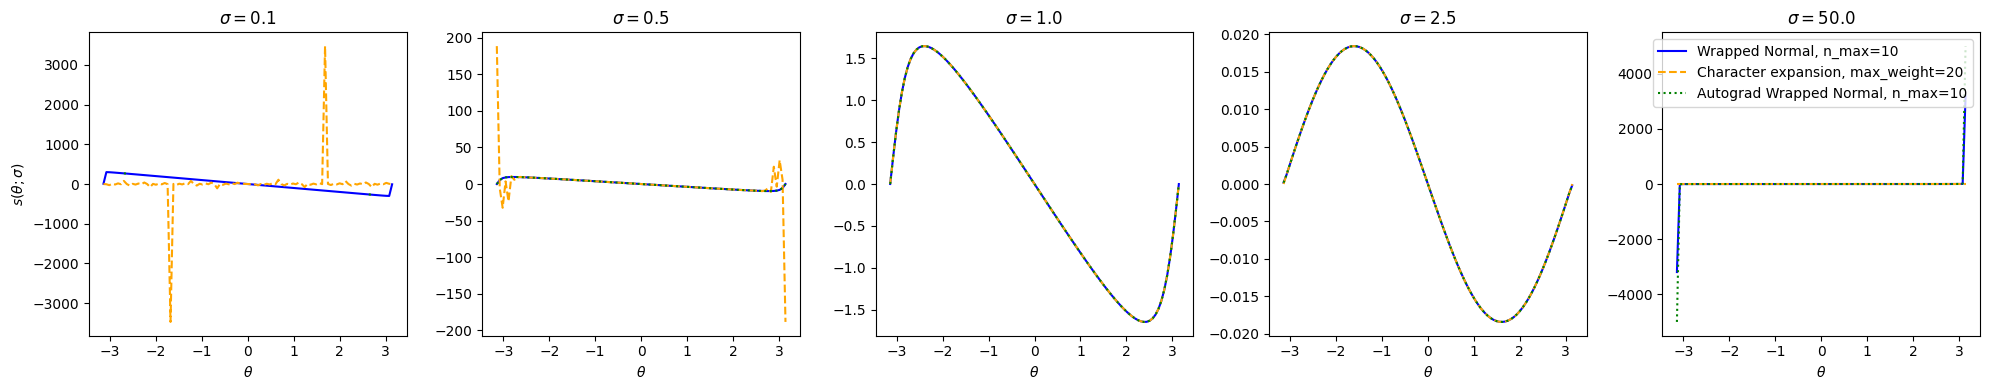

In [6]:
def plot_su2_score_hk():
    eps = 1e-4  # for endpoint stability
    xs = torch.linspace(-np.pi + eps, np.pi - eps, 100)
    sigmas = [0.1, 0.5, 1.0, 2.5, 50.0]

    fig, axes = plt.subplots(1, len(sigmas), figsize=(4*len(sigmas), 4))
    axes[0].set_ylabel(r'$s(\theta; \sigma)$')
    for sigma, ax in zip(sigmas, axes):
        width = sigma * torch.ones(xs.shape[0])
        ax.set_xlabel(r'$\theta$')
        ax.set_title(rf'$\sigma = {sigma}$')

        # Wrapped normal HK score
        n_max = 10
        score = sun_score_hk(xs[:, None], width=width, n_max=n_max)[:, 0]  # only first component
        ax.plot(xs, score, color='blue', ls='-', label=f'Wrapped Normal, {n_max=}')

        # Character expansion HK score
        max_weight = 20
        score = sun_score_dual_hk(xs[:, None], width=width, max_weight=max_weight)[:, 0]
        ax.plot(xs, score, color='orange', ls='--', label=f'Character expansion, {max_weight=}')

        # Autograd HK score
        n_max = 10
        score = sun_score_hk_autograd(xs[:, None], width=sigma, n_max=n_max)[:, 0]
        ax.plot(xs, score, color='green', ls=':', label=f'Autograd Wrapped Normal, {n_max=}')

    axes[-1].legend()
    fig.tight_layout()
    fig.show()

plot_su2_score_hk()